### **Pittsburgh** Tourism
### How does Pittsburgh rank against other Philadelphia
### Use data to compare cities in destinations:
   *hotels* <br/>
   *events* <br/>
   *food*
    

In [1]:
#INSTALL AND IMPORT NECESSARY PACKAGES
!pip install requests
!conda install -c conda-forge folium=0.5.0 --yes
import pandas as pd
import numpy as np
import csv 
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import folium
import json
from sklearn.cluster import KMeans

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-

In [2]:
from pandas.io.json import json_normalize

CLIENT_ID = 'SGD2KZBNQOVIDUSTL5OM3V4VG5T1OUKUMFD2RTTTLXBPI0UR' # your Foursquare ID
CLIENT_SECRET = 'IJ4AUCDS5L0ZNDZ2H5PA1CK4FUZ505VRKJZOWBFLIFBPFV0Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: SGD2KZBNQOVIDUSTL5OM3V4VG5T1OUKUMFD2RTTTLXBPI0UR
CLIENT_SECRET:IJ4AUCDS5L0ZNDZ2H5PA1CK4FUZ505VRKJZOWBFLIFBPFV0Z


# GET CATEGORIES OF PITTSBURGH VENUES

In [3]:
limit = 100
radius = 20000
pgh_lat = 40.4406
pgh_lng = -79.9959
FourSquarePGH = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    pgh_lat, 
    pgh_lng, 
    radius, 
    limit)

results = requests.get(FourSquarePGH).json()
results

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


## GET Pittsburgh Hotel Venues

In [4]:
#Variable for Hotel venues
hotel_query = 'Hotel'

#Variable for Entertainment categories
ent_query = '4d4b7104d754a06370d81259'

urlPGH = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, pgh_lat, pgh_lng, VERSION, hotel_query, radius, limit)
hotelresultsPGH = requests.get(urlPGH).json()



In [5]:
import requests
import json
entPGHlink = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    pgh_lat, 
    pgh_lng, 
    VERSION, 
    ent_query,
    radius)
entPGHresults = requests.get(entPGHlink).json()
eventPGH = entPGHresults['response']['venues']

TEMPeventPGH = json_normalize(eventPGH)


##Organize Pittsburgh Entertainment list to be a dataframe with just Category ID and Category Name
categoryTEMPpgh = list(TEMPeventPGH.categories)
categoryTEMPpgh = pd.DataFrame(list(TEMPeventPGH.categories))
categoryTEMPpgh.insert(1, 'id', str)
categoryTEMPpgh.insert(2, 'name', str)
categoryTEMPpgh = categoryTEMPpgh[0:].astype(str)
categoryTEMPpgh = categoryTEMPpgh.rename({0: 'categories'}, axis=1)
categoryTEMPpgh = categoryTEMPpgh['categories'].str.split(',', 1, expand=True)
categoryTEMPpgh = categoryTEMPpgh.rename({0: 'id'}, axis=1)
categoryTEMPpgh = categoryTEMPpgh.rename({1: 'name'}, axis=1)
categoryTEMPpgh["id"] = categoryTEMPpgh["id"].str.replace("{'id': '", '')
categoryTEMPpgh["id"] = categoryTEMPpgh["id"].str.strip("''")
categoryTEMPpgh["name"] = categoryTEMPpgh["name"].str.replace("'name': '", '')
categoryTEMPpgh["name"] = categoryTEMPpgh["name"].str.replace("'name': '", '')
categoryTEMPpgh["name"] = categoryTEMPpgh["name"].str.replace("(,).*","")
categoryTEMPpgh["name"] = categoryTEMPpgh["name"].str.strip("''")
Entertainment_PGH = pd.DataFrame(categoryTEMPpgh)

Entertainment_PGH = Entertainment_PGH.join(TEMPeventPGH, lsuffix='CategoryID', rsuffix='Venue ID')
Entertainment_PGH = Entertainment_PGH.drop(Entertainment_PGH.loc[:, 'categories':'location.neighborhood'].columns, axis = 1) 
Entertainment_PGH = Entertainment_PGH.drop(Entertainment_PGH.columns[0], axis = 1) 
Entertainment_PGH = Entertainment_PGH.rename({'nameCategoryID': 'Entertainment Category', 'idVenue ID': 'Venue ID', 'nameVenue ID': 'Venue Name'}, axis =1)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


## Philadelphia Venues

In [6]:
limit = 100
radius = 20000
philat = 39.9526
philang = -75.1652
FourSquarePhil = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    philat, 
    philang, 
    radius, 
    limit)

resultsPhil = requests.get(FourSquarePhil).json()
resultsPhil

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

from pandas.io.json import json_normalize
venuesPhil = resultsPhil['response']['groups'][0]['items']
    
nearby_venuesPhil = json_normalize(venuesPhil) # flatten JSON

# filter columns
filtered_columnsPhil = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesPhil =nearby_venuesPhil.loc[:, filtered_columnsPhil]

# filter the category for each row
nearby_venuesPhil['venue.categories'] = nearby_venuesPhil.apply(get_category_type, axis=1)

# clean columns
nearby_venuesPhil.columns = [col.split(".")[-1] for col in nearby_venuesPhil.columns]
    

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [7]:
#Variable for Entertainment categories
ent_queryPhil = '4d4b7104d754a06370d81259'

urlPhil = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, philat, philang, VERSION, hotel_query, radius, limit)
hotelresultsPhil = requests.get(urlPhil).json()

In [8]:
#Philadelphia HOTELS
hvenuePhil = hotelresultsPhil['response']['venues']
tempPhil = pd.DataFrame() 
tempPhil = json_normalize(hvenuePhil)
PhilHotel = pd.DataFrame()
PhilHotel = tempPhil[['id', 'name', 'location.lat', 'location.lng']]



entPhillink = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    philat, 
    philang, 
    VERSION, 
    ent_queryPhil,
    radius)
entPhilresults = requests.get(entPhillink).json()
eventPhil = entPhilresults['response']['venues']

TEMPeventPhil = json_normalize(eventPhil)


##Organize Philadelphia Entertainment list to be a dataframe with just Category ID and Category Name
categoryTEMPphil = list(TEMPeventPhil.categories)
categoryTEMPphil = pd.DataFrame(list(TEMPeventPhil.categories))
categoryTEMPphil.insert(1, 'id', str)
categoryTEMPphil.insert(2, 'name', str)
categoryTEMPphil = categoryTEMPphil[0:].astype(str)
categoryTEMPphil = categoryTEMPphil.rename({0: 'categories'}, axis=1)
categoryTEMPphil = categoryTEMPphil['categories'].str.split(',', 1, expand=True)
categoryTEMPphil = categoryTEMPphil.rename({0: 'id'}, axis=1)
categoryTEMPphil = categoryTEMPphil.rename({1: 'name'}, axis=1)
categoryTEMPphil["id"] = categoryTEMPphil["id"].str.replace("{'id': '", '')
categoryTEMPphil["id"] = categoryTEMPphil["id"].str.strip("''")
categoryTEMPphil["name"] = categoryTEMPphil["name"].str.replace("'name': '", '')
categoryTEMPphil["name"] = categoryTEMPphil["name"].str.replace("'name': '", '')
categoryTEMPphil["name"] = categoryTEMPphil["name"].str.replace("(,).*","")
categoryTEMPphil["name"] = categoryTEMPphil["name"].str.strip("''")
Entertainment_Phil = pd.DataFrame(categoryTEMPphil)

Entertainment_Phil = Entertainment_Phil.join(TEMPeventPhil, lsuffix='CategoryID', rsuffix='Venue ID')
Entertainment_Phil = Entertainment_Phil.drop(Entertainment_Phil.loc[:, 'categories':'location.neighborhood'].columns, axis = 1) 
Entertainment_Phil = Entertainment_Phil.drop(Entertainment_Phil.columns[0], axis = 1) 
Entertainment_Phil = Entertainment_Phil.rename({'nameCategoryID': 'Entertainment Category', 'idVenue ID': 'Venue ID', 'nameVenue ID': 'Venue Name'}, axis =1)



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [9]:
PhilHotel.iloc[0:20, [1]]

,name
0,The Notary Hotel
1,Club Quarters Hotel in Philadelphia
2,Loews Philadelphia Hotel
3,Kimpton Hotel Palomar Philadelphia
4,Cambria Hotel Philadelphia Downtown Center City
5,Four Seasons Hotel Philadelphia at Comcast Center
6,The Bellevue Hotel
7,Sheraton Philadelphia Downtown Hotel
8,The Independent Hotel
9,Parker-Spruce Hotel


# Number of Category types in Philadelphia

In [10]:
#number of category types in Philadelphia
PHILnum_of_category_type = pd.DataFrame(Entertainment_Phil.groupby('Entertainment Category').count())
PHILnum_of_category_type.rename(columns = {'Venue ID':'Number of Categories'}, inplace = True) 
PHILnum_of_category_type = PHILnum_of_category_type.drop(columns = ['Venue Name', 'delivery.id', 'delivery.url', 'delivery.provider.name','delivery.provider.icon.prefix'
                                        , 'delivery.provider.icon.sizes', 'delivery.provider.icon.name'])

# Economic Data of Pittsburgh and Philadelphia

In [116]:
# General Job Market and Socio Economic Ranking (WalletHub)
emp = pd.DataFrame(pd.read_excel('Employment.xlsx'))
emp = emp.drop([0, 0])
EMPrank = pd.DataFrame()
PTemp = emp.loc[emp['City'] == 'Pittsburgh, PA']
Philemp = emp.loc[emp['City'] == 'Philadelphia, PA']
EMPrank = EMPrank.append(PTemp, ignore_index = True) 
EMPrank = EMPrank.append(Philemp, ignore_index = True) 


In [129]:
# Real GDP for Pittsburgh and Philadelphia
gdp = pd.DataFrame(pd.read_excel('GDPcityData.xlsx'))
gdp = gdp.dropna(axis = 0)
gdp

,Unnamed: 0,2015 Thousands of chained dollars\t\t\t,2016 Thousands of chained dollars,2017 Thousands of chained dollars,2018 Thousands of chained dollars,2018 Rank In State,2016 Percent change,2017 Percent change,2018 Percent change,2018 Rank in State
0,Allegheny,83017798.0,82618284.0,84107607.0,86799511.0,2.0,-0.5,1.8,3.2,14.0
1,Philadelphia,105086826.0,110272136.0,106852689.0,110734916.0,1.0,4.9,-3.1,3.6,6.0


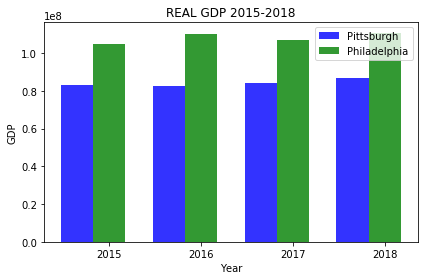

In [138]:
## import numpy as np
import matplotlib.pyplot as plt

# 2015 GDP
pgh_gdp15    = gdp.iloc[0, 1]
phi_gdp15    = gdp.iloc[1, 1]

# 2016 GDP
pgh_gdp16    = gdp.iloc[0, 2]
phi_gdp16    = gdp.iloc[1, 2]

# 2017 GDP
pgh_gdp17    = gdp.iloc[0, 3]
phi_gdp17    = gdp.iloc[1, 3]

# 2018 GDP
pgh_gdp18    = gdp.iloc[0, 4]
phi_gdp18    = gdp.iloc[1, 4]

#Chart Data
n_gdp = 4
pgh_gdp = (pgh_gdp15, pgh_gdp16, pgh_gdp17, pgh_gdp18)
phi_gdp = (phi_gdp15 ,phi_gdp16, phi_gdp17, phi_gdp18)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_gdp)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, pgh_gdp, bar_width,
alpha=opacity,
color='b',
label='Pittsburgh')

rects2 = plt.bar(index + bar_width, phi_gdp, bar_width,
alpha=opacity,
color='g',
label='Philadelphia')

plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('REAL GDP 2015-2018')
plt.xticks(index + bar_width, ('2015', '2016', '2017', '2018'))
plt.legend()

plt.tight_layout()
plt.show()

# Education and Education Attainment For Pittsburgh and Philadelphia by County

In [61]:
eduMain = pd.DataFrame(pd.read_excel('EduMain.xlsx'))
eduMain = eduMain.rename(columns=eduMain.iloc[0])
eduMain = eduMain.drop([0])
eduMain = eduMain.dropna(axis=1)

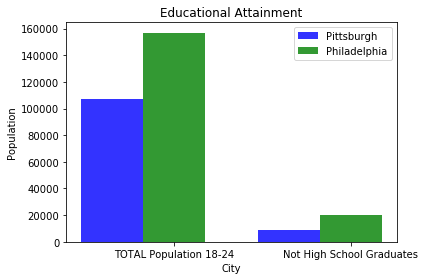

In [115]:
import numpy as np
import matplotlib.pyplot as plt

# 18-24 Total Population Population
pgh_pop1824    = eduMain.iloc[0, 2]
phi_pop1824    = eduMain.iloc[1, 2]

# Less than High School
pgh_lessthen12    = eduMain.iloc[0, 8]
phi_lessthen12    = eduMain.iloc[1, 8]

#Chart Data
n_groups = 2
pgh_chartdata = (pgh_pop1824, pgh_lessthen12)
phi_chartdata = (phi_pop1824 ,phi_lessthen12)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, pgh_chartdata, bar_width,
alpha=opacity,
color='b',
label='Pittsburgh')

rects2 = plt.bar(index + bar_width, phi_chartdata, bar_width,
alpha=opacity,
color='g',
label='Philadelphia')

plt.xlabel('City')
plt.ylabel('Population')
plt.title('Educational Attainment')
plt.xticks(index + bar_width, ('TOTAL Population 18-24', 'Not High School Graduates'))
plt.legend()

plt.tight_layout()
plt.show()

In [140]:
AllGrades = pd.DataFrame(pd.read_excel('HStoCollege.xlsx'))

,AGE BY EDUCATIONAL ATTAINMENT,Allegheny County,Philadelhia County
0,Population 18 to 24 years,107418,156776
1,Less than high school graduate,8853,19901
2,High school graduate (includes equivalency),34050,53190
3,Some college or associate's degree,41076,59703
4,Bachelor's degree or higher,23439,23982
5,Population 25 years and over,883285,1083271
6,Less than 9th grade,11821,55561
7,"9th to 12th grade, no diploma",32022,97464
8,High school graduate (includes equivalency),234022,358281
9,"Some college, no degree",142757,175629


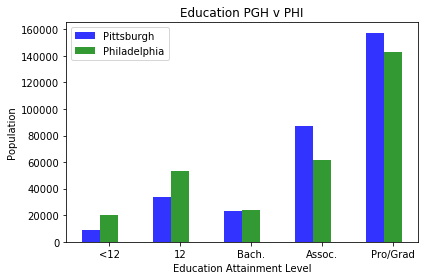

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# Less then High School
pghlessthen12 = AllGrades.iloc[1, 1]
philessthen12 = AllGrades.iloc[1, 2]

# High School Graduate
pghHS = AllGrades.iloc[2, 1]
phiHS = AllGrades.iloc[2, 2]

# Bachelors
pghB = AllGrades.iloc[4, 1]
phiB = AllGrades.iloc[4, 2]

# Associates
pghA = AllGrades.iloc[10, 1]
phiA = AllGrades.iloc[10, 2]

# Professional / Graduate Degree
pghPG = AllGrades.iloc[12, 1]
phiPG = AllGrades.iloc[12, 2]


#Chart Data
n_g = 5
pgh_edu_chart = (pghlessthen12, pghHS, pghB, pghA, pghPG)
phi_edu_chart = (philessthen12, phiHS, phiB, phiA, phiPG)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_g)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, pgh_edu_chart, bar_width,
alpha=opacity,
color='b',
label='Pittsburgh')

rects2 = plt.bar(index + bar_width, phi_edu_chart, bar_width,
alpha=opacity,
color='g',
label='Philadelphia')

plt.xlabel('Education Attainment Level')
plt.ylabel('Population')
plt.title('Education PGH v PHI')
plt.xticks(index + bar_width, ('<12', '12', 'Bach.', 'Assoc.', 'Pro/Grad'))
plt.legend()

plt.tight_layout()
plt.show()